# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
!pip install scikit-learn==0.19

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Loading in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',';')

# Loading in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', ';')

In [3]:
# Checking the structure of the data after it's loaded 

# Finding the number of rows and columns in the azdias dataset
azdias.shape

(891221, 85)

In [4]:
# Viewing the first 5 rows of the azdias dataset

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Finding the number of columns and rows in the feat_info dataset

feat_info.shape

(85, 4)

In [6]:
# Viewing the first 5 rows of the feat_info dataset

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# Checking the types of measurement for each variable
measurement_types = feat_info['type'].tolist()

# Counting the occurrences of each measurement_type
measurement_type_counts = collections.Counter(measurement_types)

# Printing the count of each measurement_type
for measurement_type, count in measurement_type_counts.items():
    print(f"{measurement_type}: {count}")

categorical: 21
ordinal: 49
numeric: 7
mixed: 7
interval: 1


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Creating a copy of the azdias and new_feat dataframes in order to manipulate the data without changing the original datasets
na_azdias = azdias[:]

new_feat_info = feat_info[:]

In [9]:
# # Retrieving missing value codes from feat_info DataFrame
# missing_value_codes = new_feat_info.iloc[:, 3].values
# print(missing_value_codes)


In [10]:
# Finding missing values

missing_codes_str = feat_info.iloc[3]['missing_or_unknown']

# Identifying the columns with missing value codes
missing_cols = new_feat_info[new_feat_info['missing_or_unknown'] != '[]']['attribute'].tolist()

# Replacing missing value codes with NaNs
for col in missing_cols:
    missing_codes = new_feat_info.loc[new_feat_info['attribute'] == col, 'missing_or_unknown'].values[0]
    missing_codes = missing_codes.strip('][').split(',')
    for code in missing_codes:
        code = code.strip()
        if code != 'X' and code != 'XX':
            na_azdias[col] = np.where(na_azdias[col] == int(code), np.nan, na_azdias[col])

In [11]:
# # Converting missing value codes to NaNs in azdias DataFrame
# for column in na_azdias.columns:
#     na_azdias[column] = na_azdias[column].replace(missing_value_codes, np.nan)

In [12]:
# Retrieving missing value codes from feat_info DataFrame
missing_value_codes = new_feat_info.iloc[:, 3].values
print(missing_value_codes)

# Viewing the amount of missing data in each column in descending order
missing_values_counts = []

for col in missing_cols:
    missing_values_counts.append((col, na_azdias[col].isnull().sum()))

# Sorting the list in descending order based on the missing value counts
sorted_missing_values = sorted(missing_values_counts, key=lambda x: x[1], reverse=True)

# Printing the missing value counts in descending order
for col, count in sorted_missing_values:
    print(f"Column: {col}")
    print("Missing Values Count:", count)
    print()

['[-1,0]' '[-1,0,9]' '[-1,0]' '[0]' '[-1]' '[-1]' '[-1]' '[-1]' '[-1]'
 '[-1]' '[-1]' '[0]' '[]' '[]' '[-1,0]' '[0]' '[0]' '[0]' '[0]' '[0]' '[0]'
 '[-1,0]' '[-1,0]' '[0]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'
 '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'
 '[-1,9]' '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1,9]' '[0]' '[]' '[]' '[-1,0]'
 '[-1]' '[-1,0]' '[-1,0]' '[0]' '[]' '[-1,0]' '[]' '[0]' '[-1]' '[-1]'
 '[-1,X]' '[XX]' '[-1,XX]' '[-1]' '[-1]' '[-1]' '[-1]' '[-1,0]' '[-1,0]'
 '[-1]' '[-1]' '[-1]' '[]' '[-1,0]' '[]' '[]' '[-1,0]' '[]' '[-1]' '[-1]'
 '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1]' '[-1,9]' '[-1,0]' '[-1,9]']
Column: TITEL_KZ
Missing Values Count: 889061

Column: AGER_TYP
Missing Values Count: 685843

Column: KK_KUNDENTYP
Missing Values Count: 584612

Column: KBA05_BAUMAX
Missing Values Count: 476524

Column: GEBURTSJAHR
Missing Values Count: 392318

Column: ALTER_HH
Missing Values Count: 310267

Column: KKK
Missing Values Count: 158064

Column: REGIOTYP


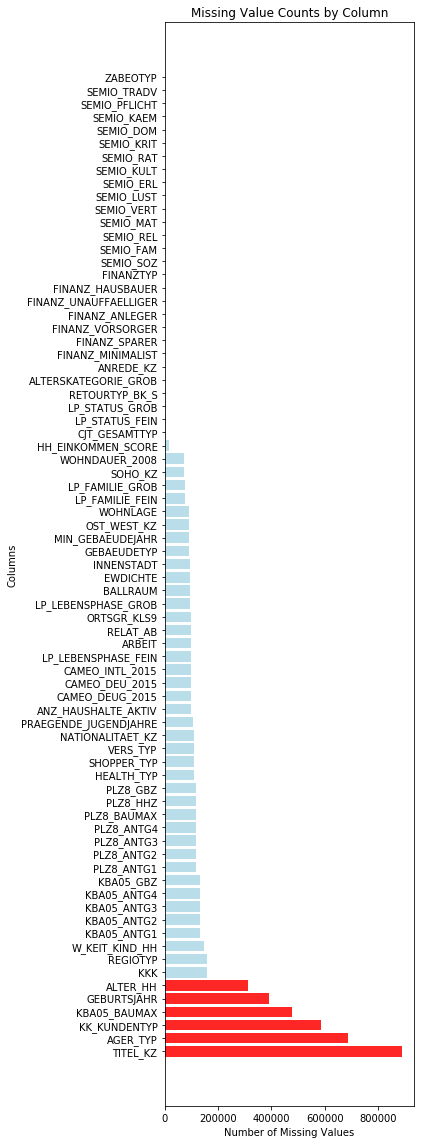

In [13]:
# Setting the threshold for highlighting columns
threshold = 300000

# Creating a list of colors based on the missing value counts
colors = ['red' if count > threshold else 'lightblue' for col, count in sorted_missing_values]

# Creating a horizontal bar chart
columns, missing_values_count = zip(*sorted_missing_values)
plt.figure(figsize=(6, 16))
plt.barh(range(len(columns)), missing_values_count, color=colors, alpha=0.85)
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Missing Value Counts by Column')
plt.yticks(range(len(columns)), columns)
plt.tight_layout()
plt.show()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# # Check number of missing values in na_azdias DataFrame and sorting them in descending order
# missing_values_count = na_azdias.isnull().sum()
# sorted_missing_values = missing_values_count.sort_values(ascending=False)

# # Extracting the column names and missing value counts
# columns = [col for col, _ in sorted_missing_values.items()]
# counts = [count for _, count in sorted_missing_values.items()]


In [15]:
# Check number of missing values in na_azdias DataFrame
missing_values_count = na_azdias.isnull().sum()

# Viewing the count of missing values for the first 5 columns
missing_values_count.head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

In [16]:
# Viewing the amount of missing data in each column in descending order
missing_values_counts = []

for col in missing_cols:
    missing_values_counts.append((col, na_azdias[col].isnull().sum()))

# Sorting the list in descending order based on the missing value counts
sorted_missing_values = sorted(missing_values_counts, key=lambda x: x[1], reverse=True)

# Printing the missing value counts in descending order
for col, count in sorted_missing_values:
    print(f"Column: {col}")
    print("Missing Values Count:", count)
    print()

Column: TITEL_KZ
Missing Values Count: 889061

Column: AGER_TYP
Missing Values Count: 685843

Column: KK_KUNDENTYP
Missing Values Count: 584612

Column: KBA05_BAUMAX
Missing Values Count: 476524

Column: GEBURTSJAHR
Missing Values Count: 392318

Column: ALTER_HH
Missing Values Count: 310267

Column: KKK
Missing Values Count: 158064

Column: REGIOTYP
Missing Values Count: 158064

Column: W_KEIT_KIND_HH
Missing Values Count: 147988

Column: KBA05_ANTG1
Missing Values Count: 133324

Column: KBA05_ANTG2
Missing Values Count: 133324

Column: KBA05_ANTG3
Missing Values Count: 133324

Column: KBA05_ANTG4
Missing Values Count: 133324

Column: KBA05_GBZ
Missing Values Count: 133324

Column: PLZ8_ANTG1
Missing Values Count: 116515

Column: PLZ8_ANTG2
Missing Values Count: 116515

Column: PLZ8_ANTG3
Missing Values Count: 116515

Column: PLZ8_ANTG4
Missing Values Count: 116515

Column: PLZ8_BAUMAX
Missing Values Count: 116515

Column: PLZ8_HHZ
Missing Values Count: 116515

Column: PLZ8_GBZ
Missing

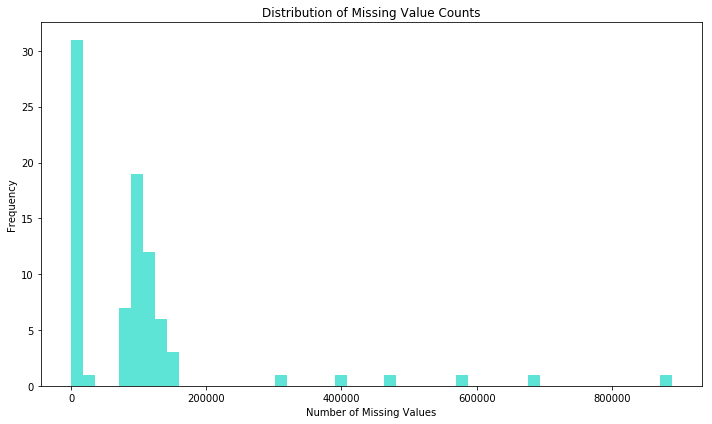

In [17]:
# Creating a histogram to show the distribution of missing value counts of each column
plt.figure(figsize=(10, 6))
plt.hist(missing_values_count, bins=50, color='turquoise', alpha=0.85)
plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Value Counts')
plt.tight_layout()
plt.show()

In [18]:
# Creating a list of columns to remove
outlier_columns = [col for col, count in sorted_missing_values if count > 300000]
outlier_columns

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [19]:
# Removing the outlier columns from the na_azdias dataset
na_azdias = na_azdias.drop(outlier_columns, axis=1)

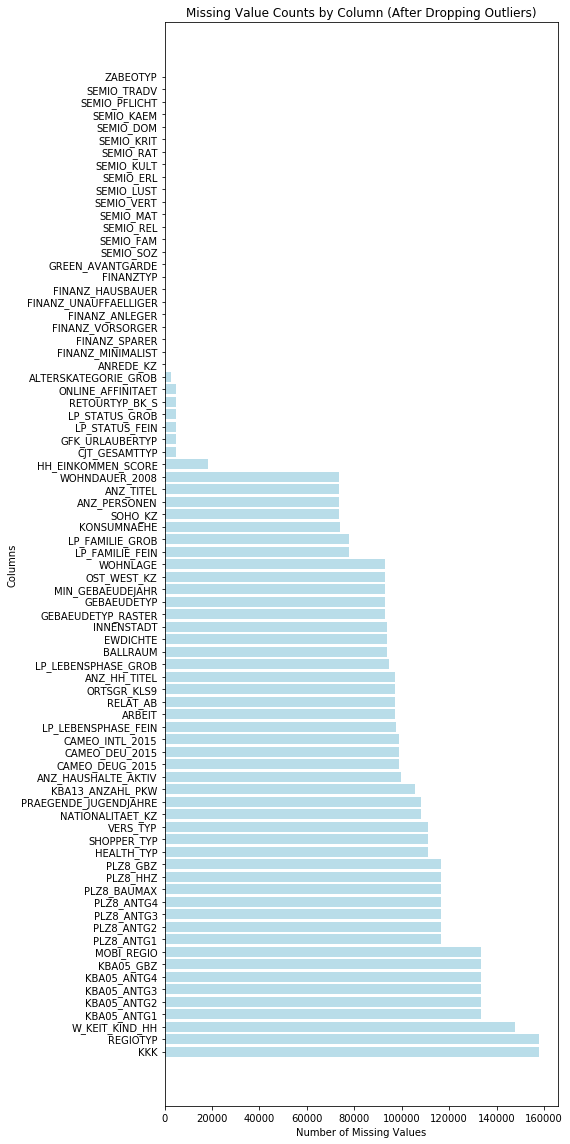

In [20]:
# Creating an updated bar chart without the outliers

# Calculating the missing value counts for each column in the updated dataset
missing_values_counts = []

for col in na_azdias.columns:
    missing_values_counts.append((col, na_azdias[col].isnull().sum()))

# Sorting the list in descending order based on the missing value counts
sorted_missing_values = sorted(missing_values_counts, key=lambda x: x[1], reverse=True)

# Extracting the column names and missing value counts
columns = [col for col, _ in sorted_missing_values]
counts = [count for _, count in sorted_missing_values]

# Creating a horizontal bar chart
plt.figure(figsize=(8, 16))
plt.barh(range(len(columns)), counts, color='lightblue', alpha=0.85)
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Missing Value Counts by Column (After Dropping Outliers)')
plt.yticks(range(len(columns)), columns)
plt.tight_layout()
plt.show()

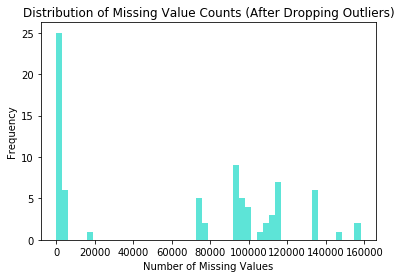

In [21]:
# Creating an updating histogram without the outliers

# Calculating the missing value counts for each column in the updated dataset
missing_values_count = na_azdias.isnull().sum()

# Creating a histogram of the missing value counts
plt.hist(missing_values_count, bins=50, color='turquoise', alpha=0.85)
plt.xlabel('Number of Missing Values')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Value Counts (After Dropping Outliers)')
plt.show()

### Investigating patterns in the missing data:

In [22]:
# Calculating the missing value counts for each column 
missing_value_counts = na_azdias.isnull().sum()
missing_value_counts

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
                          ...  
MIN_GEBA

In [23]:
# Sorting the missing value counts in descending order to identify columns with the highest number of missing values
sorted_missing_values = missing_value_counts.sort_values(ascending=False)
sorted_missing_values

KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
LP_LEBENSPHASE_FEIN       97632
RELAT_AB                  97375
ARBEIT                    97375
ORTSGR_KLS9               97274
                          ...  
GFK_URLA

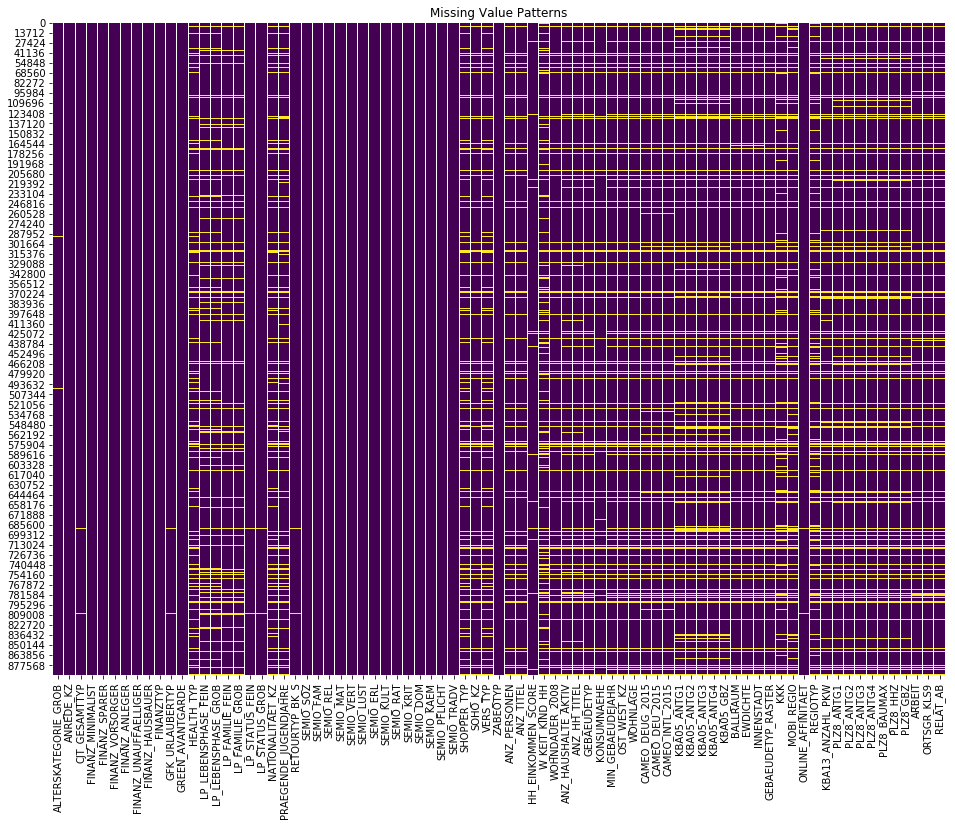

In [24]:
# Creating a heatmap to view potential patterns of missing data

import seaborn as sns

# Create a dataframe with missing value patterns
missing_value_patterns = na_azdias.isnull()

# Create a heatmap of missing value patterns
plt.figure(figsize=(16, 12))
sns.heatmap(missing_value_patterns, cmap='viridis', cbar=False)
plt.title('Missing Value Patterns')
plt.show()

### Discussion 1.1.2: Assess Missing Data in Each Column
    
#### I started by removing the outlier columns to get a better view of the data. I removed the six columns that had missing value counts over 300,000. Those columns were: 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', and 'ALTER_HH.'

#### I then did an assement of the remaining columns to find the amount of missing data in each column. Those counts ranged from 0 to 158,064. One of the patterns I noticed was that multiple columns have the exact same amount of missing values. To me, that shows there may have been an issue with the collecting or recording of the data. After creating a heatmap of the missing values, it also become obvious that many rows had large amounts of missing data. Those rows may need to be removed so that they do not skew the data.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# Finding the amount of missing data from each row
missing_data_count = na_azdias.isnull().sum(axis=1)

# Printing the missing data count for each row
print(missing_data_count)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


In [26]:
# Putting the value counts in descending order for better viewing 
unique_counts_sorted = missing_data_count.sort_values(ascending=False).value_counts()

# Printing the count of each unique value
print(unique_counts_sorted)

0     623423
47     45578
2      27938
43     27369
8      24598
5      22520
3      17423
1      15742
6      13777
7      13730
4      12609
34     10816
10      5391
15      4765
35      3910
13      3254
9       3031
33      2985
16      2513
14      2248
19      1171
11      1105
12       763
17       671
37       538
45       494
38       421
18       406
41       356
20       350
32       207
44       155
21       151
40       137
23       132
22       128
36        84
39        77
24        68
26        59
25        55
27        24
42        21
29        11
30         6
28         5
31         3
49         2
48         1
dtype: int64


In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


# Creating a boolean mask for rows with counts under 10,000
mask_under_10 = missing_data_count <= 10

# Creating two subsets based on the mask
subset_under_10 = na_azdias[mask_under_10]
subset_over_10 = na_azdias[~mask_under_10]

# Printing the number of rows in each subset
print("Subset under or equal to 10:", len(subset_under_10))
print("Subset over 10:", len(subset_over_10))



Subset under or equal to 10: 780182
Subset over 10: 111039


In [28]:
#Finding rows with missing values equal to zero to analyze the distribution of values

# Calculating the count of missing values in each row of subset_under_10
missing_value_counts = subset_under_10.isnull().sum(axis=1)

# Filtering the rows with count = 0
rows_with_zero_count = subset_under_10[missing_value_counts == 0]


In [29]:
# # Getting the first 5 rows with missing values equal to 0 to use for comparison
first_five_values = rows_with_zero_count[:5]
print(first_five_values)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   
6                   2.0        2.0            5.0                1.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   
6            5.0               1.0             5.0                    4.0   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
1               5.0     

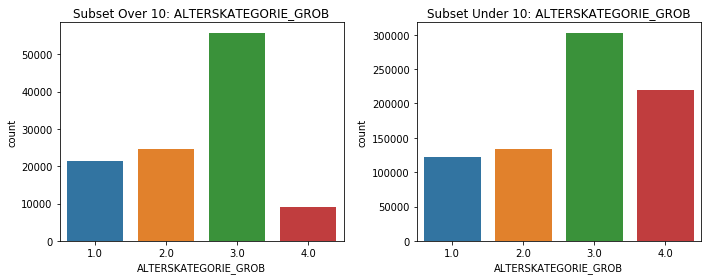

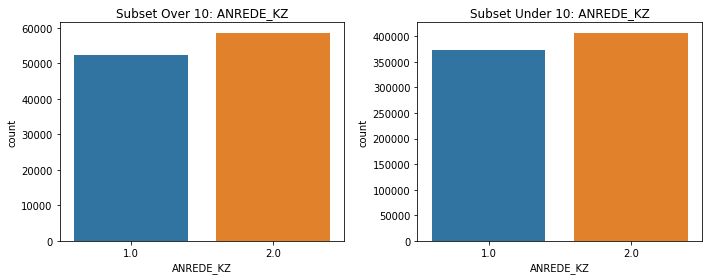

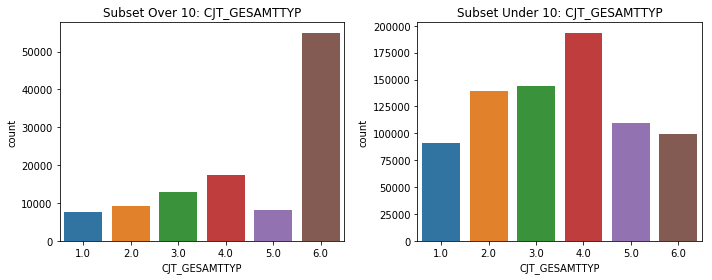

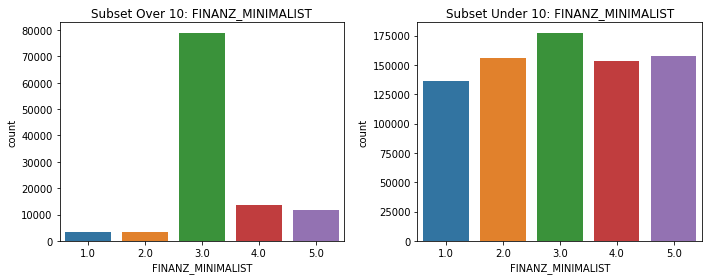

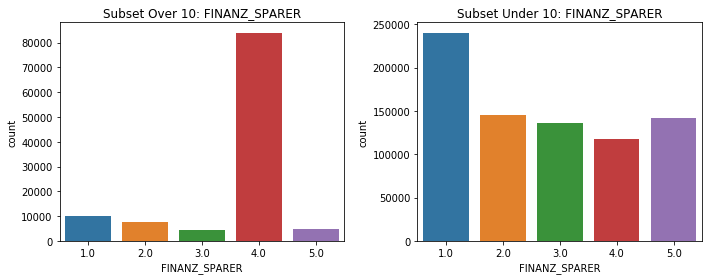

In [30]:
def compare_distribution(column):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(data=subset_over_10, x=column)
    plt.title('Subset Over 10: ' + column)
    plt.subplot(1, 2, 2)
    sns.countplot(data=subset_under_10, x=column)
    plt.title('Subset Under 10: ' + column)
    plt.tight_layout()
    plt.show()

# Calling the function for each column of interest
columns_of_interest = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER']
for column in columns_of_interest:
    compare_distribution(column)


In [31]:
# Viewing how much data would be lost if we dropped the subset_over_10

print('Rows with more than 10 missing values:', subset_over_10.shape[0], 'or', \
      np.round(subset_over_10.shape[0]*100/missing_data_count.shape[0],2), 
      '% of all data')

Rows with more than 10 missing values: 111039 or 12.46 % of all data


### Based on the vast difference between the data sets, I think it's best to focus on the subset_under_10 for further analysis so that the rows with over 10 values missing don't skew the analysis. 

In [32]:
# Saving the subset_over_10 to it's own dataframe in case it is 
#needed in the future

subset_over_10.to_csv('subset_over_10.csv', index=False)

In [33]:
# Saving the subset_uner_10 to a new name for easier viewing
new_azdias = subset_under_10

In [34]:
# Dropping subset_over_10 from na_azdias dataset

na_azdias = na_azdias.drop(subset_over_10.index)

In [35]:
new_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [36]:
new_azdias.shape

(780182, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row


#### The graphs on the left side with the Subset Over 10 data, have much fewer counts of missing values when compared to the right side with the Subset Under 10 data. 

#### Aside from 'ANREDE_KZ', there is a huge difference between the distribution of the two subsets. The outliers in the Subset Over 10 are also drastically more obvious than those of the Subset Under 10 bar graphs. 

#### Hypothetically, the data should be similarly distributed between the two subsets. The difference shown between them makes a case for a possible bias in the data and should be further investigated. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# # Excluding 'PRAEGENDE_JUGENDJAHRE'to be used for later assessment
# columns_to_drop = columns_to_drop[columns_to_drop.index != 'PRAEGENDE_JUGENDJAHRE']

# # Dropping the columns from the dataset
# na_azdias.drop(columns=columns_to_drop.index, inplace=True)

In [38]:
# Checking the types of measurement for each variable
measurement_types = new_feat_info['type'].tolist()

# Counting the occurrences of each measurement_type
measurement_type_counts = collections.Counter(measurement_types)

# Printing the count of each measurement_type
for measurement_type, count in measurement_type_counts.items():
    print(f"{measurement_type}: {count}")

categorical: 21
ordinal: 49
numeric: 7
mixed: 7
interval: 1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Filtering the categorical features based on their type of measurement
categorical_features = new_feat_info[new_feat_info['type'] == 'categorical']['attribute'].tolist()

# Printing the real names of the categorical features
print(categorical_features)

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [40]:
# Finding the multi-level categorical features 

# Filtering the multi-level categorical features based on the number of unique values
multi_level_categorical = []
for feature in new_azdias.select_dtypes(include='object'):
    num_unique_values = new_azdias[feature].nunique()
    if num_unique_values > 2:
        multi_level_categorical.append(feature)

# Removing 'CAMEO_INTL_2015' from the list of multi-level categorical features to be used in future analysis
multi_level_categorical.remove('CAMEO_INTL_2015')
       
# Printing the actual names of the multi-level categorical features
print(multi_level_categorical)

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [41]:
# Encoding the multi-level categorical features using dummy variables
azdias_encoded = pd.get_dummies(new_azdias, columns=multi_level_categorical, prefix=multi_level_categorical, drop_first=True)

# Printing the encoded dataset
print(azdias_encoded.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP        ...          CAMEO_DEU_2015_8A  \
1               5.0        1.0  

In [42]:
# Finding non-numeric columns
non_numeric_columns = azdias_encoded.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

Index(['OST_WEST_KZ', 'CAMEO_INTL_2015'], dtype='object')


In [43]:
# Excluding the 'CAMEO_INTL_2015' column - to be used in future analysis
non_numeric_columns = non_numeric_columns.drop('CAMEO_INTL_2015')  # Exclude 'CAMEO_INTL_2015' column

In [44]:
# Using one-hot encoding to create binary columns for each unique value
azdias_encoded = pd.get_dummies(azdias_encoded, columns=non_numeric_columns)

In [45]:
# Checking to ensure the encoding worked for all except 'CAMEO_INTL_2015'
new_non_numeric_columns = azdias_encoded.select_dtypes(exclude=[np.number]).columns
print(new_non_numeric_columns)

Index(['CAMEO_INTL_2015'], dtype='object')


#### Discussion:

#### I decided to re-encode the multi-level categorical data instead of dropping it so that it could still be used for further examination of the dataset. Since I had already dropped numerous values, I wanted to keep as many as I could. 

#### I found two non-numeric columns and used one-hot coding to create binary columns for each unique value. 

#### Lastly, I created a new dataframe called 'azdias_encoded',  that includes only those rows with little to no missing data as well as the engineered features. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Mapping for decade dimension
decade_mapping = {
    1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
}

# Mapping for movement dimension
movement_mapping = {
    1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0
}

# Creating PRAEGENDE_DECADE column
azdias_encoded['PRAEGENDE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

# Creating PRAEGENDE_MOVEMENT column
azdias_encoded['PRAEGENDE_MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

In [47]:
# Checking to make sure the new columns were created successfully
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,0,0,0,0,0,1,90.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,0,0,1,90.0,0.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,0,0,1,70.0,1.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,0,0,1,70.0,1.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0,0,0,0,0,0,0,1,50.0,0.0


In [48]:
# Mapping for economic dimension
def map_economic(x):
    # Check of nan first, or it will convert nan to string 'nan'
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except ValueError:
        return np.nan

# Mapping for household dimension
def map_household(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except ValueError:
        return np.nan

In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Creating CAMEO_ECONOMIC column
azdias_encoded['CAMEO_ECONOMIC'] = azdias_encoded['CAMEO_INTL_2015'].map(map_economic)

# Creating CAMEO_HOUSEHOLD column
azdias_encoded['CAMEO_HOUSEHOLD'] = azdias_encoded['CAMEO_INTL_2015'].map(map_household)

In [50]:
# Checking to ensure that the two new columns have been created successfully
azdias_encoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_ECONOMIC,CAMEO_HOUSEHOLD
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,0,0,0,1,90.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,1,90.0,0.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,1,70.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,1,70.0,1.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0,0,0,0,0,1,50.0,0.0,5.0,4.0


In [51]:
# Dropping the original columns
azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

#### For 'PRAEGENDE_JUGENDJAHRE', the feature combined information on three dimensions: generation by decade, movement, and nation. Since there weren't enough levels to differentiate between east and west, I created the two new variables to capture the two dimensions.

#### The first new column, 'PRAEGENDE_DECADE',  represents the decade information and uses a mapping directory to map the original values to the corresponding decode values. 

#### The second new variable, 'PRAEGENDE_MOVEMENT', represents the movement dimension and also uses a mapping directory to map the original values to binary values. 

#### For 'CAMEO_INTL_2015', the feature combines information based on wealth and life stage. I split the two-digit codes into two new ordinal varials: 'CAMEO_ECONOMIC' and 'CAMEO_HOUSEHOLD'.

#### The new column, 'CAMEO_ECONOMIC', represents the wealth dimension and is derived from the tens-place digit of the original codes.

#### The second new column, 'CAMEO_HOUSEHOLD', represents the life stage dimention and is derived from the ones-place digit of the original codes. 

#### I decided to drop the original columns 'PRAEGENDE_JEGENDJAHR' and 'CAMEO_INTL_2015' because they are no longer needed and wanted to clean up the dataset. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Checking the data for any issues
azdias_encoded

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_ECONOMIC,CAMEO_HOUSEHOLD
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,0,0,0,1,90.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,1,90.0,0.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,1,70.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,1,70.0,1.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0,0,0,0,0,1,50.0,0.0,5.0,4.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,0,0,0,0,0,1,80.0,1.0,2.0,2.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,1,70.0,1.0,1.0,4.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,0,0,0,0,0,1,80.0,0.0,1.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,0,0,0,0,0,1,90.0,0.0,1.0,5.0
10,3.0,2.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,6.0,...,0,1,0,0,0,1,50.0,0.0,5.0,1.0


In [53]:
# Checking for missing values before proceeding with Step 1.3
missing_values = azdias_encoded.isnull().sum()
print(missing_values)

ALTERSKATEGORIE_GROB      2625
ANREDE_KZ                    0
CJT_GESAMTTYP             3836
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP           3836
GREEN_AVANTGARDE             0
HEALTH_TYP               34528
LP_LEBENSPHASE_FEIN      46580
LP_LEBENSPHASE_GROB      43899
LP_FAMILIE_FEIN          28852
LP_FAMILIE_GROB          28852
LP_STATUS_FEIN            3836
LP_STATUS_GROB            3836
NATIONALITAET_KZ         31903
RETOURTYP_BK_S            3836
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
                         ...  
CAMEO_DEU_2015_5D            0
CAMEO_DE

In [54]:
# Filling the NaNs with the most common value from each column
azdias_filled = azdias_encoded.fillna(azdias_encoded.mode().iloc[0])

In [55]:
columns_with_missing_values = azdias_filled.columns[azdias_filled.isnull().any()].tolist()
print(columns_with_missing_values)

[]


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [69]:
def clean_dataset(azdias, feat_info):

    # Creating a copy of the azdias and new_feat dataframes in order to manipulate the data without changing the original datasets
    na_azdias = azdias.copy()
    new_feat_info = feat_info.copy()

    # Replacing missing value codes with NaNs
    for col in new_feat_info[new_feat_info['missing_or_unknown'] != '[]']['attribute']:
        missing_codes = new_feat_info.loc[new_feat_info['attribute'] == col, 'missing_or_unknown'].values[0]
        missing_codes = missing_codes.strip('][').split(',')
        for code in missing_codes:
            code = code.strip()
            if code != 'X' and code != 'XX':
                na_azdias[col] = np.where(na_azdias[col] == int(code), np.nan, na_azdias[col])

    # Removing outlier columns
    outlier_columns = [col for col, count in na_azdias.isnull().sum().items() if count > 300000]
    na_azdias = na_azdias.drop(outlier_columns, axis=1)

    # Splitting the data into subsets based on missing values count
    missing_data_count = na_azdias.isnull().sum(axis=1)
    mask_under_10 = missing_data_count <= 10
    subset_under_10 = na_azdias[mask_under_10]
    subset_over_10 = na_azdias[~mask_under_10]

    # Saving the subset_over_10 to a CSV file
    subset_over_10.to_csv('subset_over_10.csv', index=False)
    
    # Dropping subset_over_10 from na_azdias dataset
    na_azdias = na_azdias.drop(subset_over_10.index)
    
    # Filtering and encoding categorical features
    categorical_features = new_feat_info[new_feat_info['type'] == 'categorical']['attribute'].tolist()
    multi_level_categorical = [feature for feature in subset_under_10.select_dtypes(include='object') if subset_under_10[feature].nunique() > 2]
    multi_level_categorical.remove('CAMEO_INTL_2015')
    azdias_encoded = pd.get_dummies(subset_under_10, columns=multi_level_categorical, prefix=multi_level_categorical, drop_first=True)

    # Finding non-numeric columns
    non_numeric_columns = azdias_encoded.select_dtypes(exclude=[np.number]).columns

    # Excluding the 'CAMEO_INTL_2015' column - to be used in future analysis
    non_numeric_columns = non_numeric_columns.drop('CAMEO_INTL_2015') # Exclude 'CAMEO_INTL_2015' column

    # Using one-hot encoding to create binary columns for each unique value
    azdias_encoded = pd.get_dummies(azdias_encoded, columns=non_numeric_columns)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # Mapping for decade dimension
    decade_mapping = {
        1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
    }

    # Mapping for movement dimension
    movement_mapping = {
        1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0
    }

    # Creating PRAEGENDE_DECADE column
    azdias_encoded['PRAEGENDE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

    # Creating PRAEGENDE_MOVEMENT column
    azdias_encoded['PRAEGENDE_MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

    # Mapping for economic dimension
    def map_economic(x):
        # Check of nan first, or it will convert nan to string 'nan'
        try:
            if pd.isnull(x):
                return np.nan
            else:
                return int(str(x)[0])
        except ValueError:
            return np.nan

    # Mapping for household dimension
    def map_household(x):
        try:
            if pd.isnull(x):
                return np.nan
            else:
                return int(str(x)[1])
        except ValueError:
            return np.nan

    # Creating CAMEO_ECONOMIC column
    azdias_encoded['CAMEO_ECONOMIC'] = azdias_encoded['CAMEO_INTL_2015'].map(map_economic)

    # Creating CAMEO_HOUSEHOLD column
    azdias_encoded['CAMEO_HOUSEHOLD'] = azdias_encoded['CAMEO_INTL_2015'].map(map_household)

    # Dropping the original columns
    azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

    # Filling the NaNs with the most common value from each column
    azdias_filled = azdias_encoded.fillna(azdias_encoded.mode().iloc[0])

    return azdias_filled

In [70]:
cleaned_azdias = clean_dataset(azdias, feat_info)
columns_with_missing_values = cleaned_azdias.columns[cleaned_azdias.isnull().any()].tolist()
print(columns_with_missing_values)

ALTERSKATEGORIE_GROB      2625
ANREDE_KZ                    0
CJT_GESAMTTYP             3836
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP           3836
GREEN_AVANTGARDE             0
HEALTH_TYP               34528
LP_LEBENSPHASE_FEIN      46580
LP_LEBENSPHASE_GROB      43899
LP_FAMILIE_FEIN          28852
LP_FAMILIE_GROB          28852
LP_STATUS_FEIN            3836
LP_STATUS_GROB            3836
NATIONALITAET_KZ         31903
RETOURTYP_BK_S            3836
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
                         ...  
CAMEO_DEU_2015_5D            0
CAMEO_DE

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [61]:
# Checking for NaN values in the dataset
nan_counts = azdias_encoded.isnull().sum()

# Printing the columns with NaN values and their corresponding counts
print("Columns with NaN values:")
print(nan_counts[nan_counts > 0])

Columns with NaN values:
ALTERSKATEGORIE_GROB     2625
CJT_GESAMTTYP            3836
GFK_URLAUBERTYP          3836
HEALTH_TYP              34528
LP_LEBENSPHASE_FEIN     46580
LP_LEBENSPHASE_GROB     43899
LP_FAMILIE_FEIN         28852
LP_FAMILIE_GROB         28852
LP_STATUS_FEIN           3836
LP_STATUS_GROB           3836
NATIONALITAET_KZ        31903
RETOURTYP_BK_S           3836
SHOPPER_TYP             34528
VERS_TYP                34528
W_KEIT_KIND_HH          56287
ANZ_HAUSHALTE_AKTIV      5741
ANZ_HH_TITEL             3234
KONSUMNAEHE                51
KBA05_ANTG1             24476
KBA05_ANTG2             24476
KBA05_ANTG3             24476
KBA05_ANTG4             24476
KBA05_GBZ               24476
BALLRAUM                  544
EWDICHTE                  544
INNENSTADT                544
GEBAEUDETYP_RASTER          5
KKK                     54797
MOBI_REGIO              24476
ONLINE_AFFINITAET        3836
REGIOTYP                54797
KBA13_ANZAHL_PKW         5664
PLZ8_ANTG1     

In [62]:
# Filling the NaNs with the most common value from each column
azdias_filled = azdias_encoded.fillna(azdias_encoded.mode().iloc[0])

In [63]:
# Checking to ensure the NaNs have been filled

# Checking for NaN values in the dataset
nan_counts = azdias_filled.isnull().sum()

# Printing the columns with NaN values and their corresponding counts
print("Columns with NaN values:")
print(nan_counts[nan_counts > 0])


Columns with NaN values:
Series([], dtype: int64)


In [64]:
azdias_filled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_ECONOMIC,CAMEO_HOUSEHOLD
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,0,0,0,0,0,1,90.0,1.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0,0,0,0,0,1,90.0,0.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0,0,0,0,0,1,70.0,1.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,0,0,0,0,0,1,70.0,1.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,0,0,0,0,0,1,50.0,0.0,5.0,4.0


In [ ]:
# Applying feature scaling to the general population demographics data.

# Creating an instance of the StandardScaler class
scaler = StandardScaler()

# Fitting and transforming data
azdias_scaled = scaler.fit_transform(azdias_filled)

In [ ]:
# Converting the scaled data to a DataFrame
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias_filled.columns)

In [ ]:
azdias_scaled_df.head()

In [ ]:
azdias_scaled_df.columns

In [ ]:
azdias_scaled_df.shape

In [ ]:
# Viewing histograms of subplots of each variable

# Calculate the number of rows and columns for the subplot grid
num_cols = len(azdias_scaled_df.columns)
num_rows = (num_cols - 1) // 5 + 1

# Create the subplot grid
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, 3*num_rows))

# Iterate over each column and plot the histogram
for i, column in enumerate(azdias_scaled_df.columns):
    ax = axes[i // 5, i % 5]  # Get the corresponding subplot
    azdias_scaled_df[column].hist(ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

### Discussion 2.1: Apply Feature Scaling

#### First I checked the dataset for NaNs and filled them with the most common values of thier respective columns. After ensuring that the missing values had been filled successfully I applied feature scaling to the general population demographics data of the 'azdias_filled' dataset. This helps to standardize the range of features/variables in the dataset. It ensures that the features are on a similar scale in order to improve the performance of the machine learning algorithm. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
azdias_scaled_df.head()

In [ ]:
num_features = azdias_scaled_df.shape[1]
print("Number of features in azdias_scaled_df:", num_features)

In [ ]:
from sklearn.decomposition import PCA

# Create an instance of the PCA class
pca = PCA()

# Fit the PCA model to the data
pca.fit(azdias_scaled_df)

In [ ]:
# Investigate the variance accounted for by each principal component.

# Get the principal components
principal_components = pca.components_
principal_components

In [ ]:
# Getting the explained_variance_ratio to get a better understanding of the PCA results

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

In [ ]:
# Plotting the variance ratio for an easier view of the results

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

### This plot shows an 'elbow' around the number 80, indicating that after that point, the number of Principle Components no longer significantly increases the explained variance. However, after further analysis, I decided to use the smaller elbow that occurs around 60, in order to further reduce the number of components. 

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Choose the number of components to retain
num_components = 60

# Create an instance of the PCA class with the desired number of components
pca = PCA(n_components=num_components)

# Fit the PCA model to the data
pca.fit(azdias_scaled_df)

# Transform the data using the fitted PCA model
azdias_pca = pca.transform(azdias_scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

### After running the PCA, I looked at the explained_variance to determine which components were more important in capturing the variability of the data. The plot created from the cumulative_variance_ratio showed a very obvious "elbow" in the data around the number 80, so that is the number of components I had originally wanted to retain. However, the dataset was still too large and kept crashing the kernal, so I decided to shrink the data to the smaller 'elbow' around the number 60. The numbers after the elbow suggest that they no longer significantly increased the explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Define the feature_names variable
feature_names = azdias_scaled_df.columns.tolist()

In [ ]:
def print_sorted_feature_weights(pca, component_idx, feature_names):
    # Get the weights of the specified principal component
    component_weights = pca.components_[component_idx]

    # Create a dictionary mapping feature names to weights
    feature_weights = dict(zip(feature_names, component_weights))

    # Sort the feature weights by absolute value
    sorted_weights = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)

    # Split the sorted weights into positive and negative weights
    positive_weights = []
    negative_weights = []
    for feature, weight in sorted_weights:
        if weight >= 0:
            positive_weights.append((feature, weight))
        else:
            negative_weights.append((feature, weight))

    # Print the positive weights
    print("Positive Weights:")
    for feature, weight in positive_weights:
        print(f"{feature}: {weight}")

    # Print the negative weights
    print("Negative Weights:")
    for feature, weight in negative_weights:
        print(f"{feature}: {weight}")

    
    # Printing a simplified list of the feature names without the weights for easier viewing

    # Print the list of columns with positive weights
    print("List of Columns with Positive Weights:")
    for feature, _ in positive_weights:
        print(feature)

    # Print the list of columns with negative weights
    print("List of Columns with Negative Weights:")
    for feature, _ in negative_weights:
        print(feature)


In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_feature_weights(pca, 0, feature_names)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_feature_weights(pca, 1, feature_names)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_feature_weights(pca, 2, feature_names)

### Discussion 2.3: Interpret Principal Components

### Positive weights indicate a positive correlation, meaning that an increase in the feature value is associated with an increase in the principal component value. Negative weights indicate a negative correlation, meaning that an increase in the feature value is associated with a decrease in the principal component value.


#### List of Features with Positive Values from the First Principal Components:

FINANZ_SPARER
PRAEGENDE_DECADE
SEMIO_PFLICHT
SEMIO_REL
CAMEO_ECONOMIC
FINANZ_UNAUFFAELLIGER
FINANZ_ANLEGER
SEMIO_RAT
EWDICHTE
SEMIO_TRADV
ZABEOTYP
PRAEGENDE_MOVEMENT
HH_EINKOMMEN_SCORE
ORTSGR_KLS9
SEMIO_MAT
FINANZ_HAUSBAUER
ARBEIT
SEMIO_FAM
CJT_GESAMTTYP
CAMEO_DEUG_2015_9
RELAT_AB
SEMIO_KULT
ANZ_HAUSHALTE_AKTIV
CAMEO_DEUG_2015_8
GFK_URLAUBERTYP
SEMIO_KAEM
CAMEO_DEU_2015_9B
CAMEO_DEU_2015_9C
CAMEO_DEU_2015_8A
SEMIO_DOM
CAMEO_DEU_2015_9D
GEBAEUDETYP
SEMIO_KRIT
CAMEO_DEU_2015_8B
CAMEO_DEU_2015_9A
CAMEO_DEUG_2015_7
ANREDE_KZ
CAMEO_DEU_2015_7B
CAMEO_DEU_2015_8C
OST_WEST_KZ_O
CAMEO_DEU_2015_7A
ANZ_HH_TITEL
KBA13_ANZAHL_PKW
CAMEO_DEU_2015_7C
SEMIO_SOZ
CAMEO_DEU_2015_7D
CAMEO_DEU_2015_8D
CAMEO_DEU_2015_6A
CAMEO_DEU_2015_5A
CAMEO_DEU_2015_9E

#### List of Features with Negative Values from the First Principal Components:

FINANZ_MINIMALIST
LP_STATUS_GROB
LP_STATUS_FEIN
ALTERSKATEGORIE_GROB
FINANZ_VORSORGER
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
CAMEO_HOUSEHOLD
KONSUMNAEHE
SEMIO_ERL
GREEN_AVANTGARDE
SEMIO_LUST
FINANZTYP
ANZ_PERSONEN
LP_FAMILIE_GROB
LP_FAMILIE_FEIN
INNENSTADT
CAMEO_DEUG_2015_2
SEMIO_VERT
RETOURTYP_BK_S
GEBAEUDETYP_RASTER
OST_WEST_KZ_W
CAMEO_DEUG_2015_4
WOHNDAUER_2008
CAMEO_DEUG_2015_3
WOHNLAGE
BALLRAUM
CAMEO_DEU_2015_2D
CAMEO_DEU_2015_2C
CAMEO_DEU_2015_3D
MIN_GEBAEUDEJAHR
CAMEO_DEU_2015_4C
CAMEO_DEU_2015_4A
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_2B
CAMEO_DEU_2015_3C
CAMEO_DEU_2015_2A
CAMEO_DEU_2015_3B
CAMEO_DEU_2015_3A
CAMEO_DEU_2015_4B
CAMEO_DEU_2015_1E
CAMEO_DEU_2015_4D
CAMEO_DEU_2015_4E
CAMEO_DEUG_2015_5
CAMEO_DEU_2015_1C
CAMEO_DEU_2015_1B
CAMEO_DEUG_2015_6
ONLINE_AFFINITAET
CAMEO_DEU_2015_5B
CAMEO_DEU_2015_5C
ANZ_TITEL
CAMEO_DEU_2015_5F
CAMEO_DEU_2015_6B
CAMEO_DEU_2015_6E
CAMEO_DEU_2015_7E
CAMEO_DEU_2015_6D
CAMEO_DEU_2015_6F
CAMEO_DEU_2015_5E
SOHO_KZ
CAMEO_DEU_2015_6C
CAMEO_DEU_2015_5D
CAMEO_DEUG_2015_X
CAMEO_DEU_2015_XX

### In the list of features with positive values from the first principal component, we can see features like "FINANZ_SPARER" and "PRAEGENDE_DECADE" with positive weights. This suggests that individuals who are more likely to save money (FINANZ_SPARER) and belong to a specific decade (PRAEGENDE_DECADE) are positively correlated with the first principal component. On the other hand, features like "FINANZ_MINIMALIST" and "LP_STATUS_GROB" with negative weights indicate a negative correlation with the first principal component.


#### List of Features with Positive Values from the Second Principal Components:

ALTERSKATEGORIE_GROB
SEMIO_ERL
FINANZ_HAUSBAUER
FINANZ_VORSORGER
ORTSGR_KLS9
RETOURTYP_BK_S
HH_EINKOMMEN_SCORE
CAMEO_ECONOMIC
SEMIO_LUST
EWDICHTE
ANZ_HAUSHALTE_AKTIV
ARBEIT
RELAT_AB
SEMIO_KAEM
SEMIO_KRIT
CAMEO_DEUG_2015_8
ANREDE_KZ
CAMEO_DEUG_2015_9
SEMIO_DOM
FINANZTYP
ZABEOTYP
CAMEO_DEU_2015_9E
CAMEO_DEU_2015_8A
GEBAEUDETYP
CAMEO_DEU_2015_8D
OST_WEST_KZ_O
ANZ_HH_TITEL
CAMEO_DEU_2015_9D
CAMEO_DEU_2015_8C
CAMEO_DEU_2015_9C
CAMEO_DEU_2015_9B
CAMEO_DEU_2015_8B
CAMEO_DEUG_2015_7
CAMEO_DEU_2015_6E
CAMEO_DEU_2015_7C
CAMEO_DEUG_2015_6
CAMEO_DEU_2015_7B
CAMEO_DEU_2015_7D
WOHNDAUER_2008
CAMEO_DEU_2015_9A
CAMEO_DEU_2015_7E
CAMEO_DEU_2015_6F
CAMEO_DEU_2015_5D
CAMEO_DEU_2015_6C
CAMEO_DEU_2015_7A
CAMEO_DEU_2015_6D
CAMEO_DEU_2015_5E
ANZ_TITEL
CAMEO_DEU_2015_6A
GFK_URLAUBERTYP
CAMEO_DEU_2015_5F

#### List of Features with Negative Values from the Second Principal Components:

ONLINE_AFFINITAET
SEMIO_REL
PRAEGENDE_DECADE
FINANZ_UNAUFFAELLIGER
SEMIO_TRADV
SEMIO_KULT
SEMIO_PFLICHT
FINANZ_SPARER
FINANZ_ANLEGER
LP_FAMILIE_GROB
LP_FAMILIE_FEIN
LP_STATUS_FEIN
LP_LEBENSPHASE_GROB
SEMIO_FAM
LP_LEBENSPHASE_FEIN
ANZ_PERSONEN
LP_STATUS_GROB
SEMIO_MAT
SEMIO_RAT
INNENSTADT
KONSUMNAEHE
CJT_GESAMTTYP
BALLRAUM
GEBAEUDETYP_RASTER
CAMEO_DEUG_2015_2
MIN_GEBAEUDEJAHR
SEMIO_SOZ
CAMEO_DEUG_2015_4
WOHNLAGE
SEMIO_VERT
PRAEGENDE_MOVEMENT
GREEN_AVANTGARDE
KBA13_ANZAHL_PKW
CAMEO_DEUG_2015_3
CAMEO_DEU_2015_4A
CAMEO_DEU_2015_4C
CAMEO_DEU_2015_2A
CAMEO_DEU_2015_2C
CAMEO_DEU_2015_3A
CAMEO_DEU_2015_2D
CAMEO_HOUSEHOLD
CAMEO_DEU_2015_3B
CAMEO_DEU_2015_2B
FINANZ_MINIMALIST
CAMEO_DEU_2015_3C
OST_WEST_KZ_W
CAMEO_DEU_2015_4B
CAMEO_DEU_2015_3D
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_5C
CAMEO_DEU_2015_5B
CAMEO_DEU_2015_4D
CAMEO_DEUG_2015_5
CAMEO_DEU_2015_1E
CAMEO_DEU_2015_4E
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_1C
CAMEO_DEU_2015_5A
SOHO_KZ
CAMEO_DEU_2015_XX
CAMEO_DEUG_2015_X
CAMEO_DEU_2015_6B

### The list of features suggests that individuals who are in higher age categories, have a cultural-mindedness, own a home, and belong to a specific CAMEO classification level 9 are positively correlated with the second principal component. However, features like "ANREDE_KZ" (gender), "SEMIO_KAEM" (combative attitude), "SEMIO_DOM" (dominant attitude), and "SEMIO_KRIT" (critical attitude) have negative weights in the second principal component. This indicates a negative correlation with the second principal component.


#### List of Features with Positive Values from the Third Principal Components:

SEMIO_VERT
SEMIO_SOZ
SEMIO_KULT
SEMIO_FAM
HH_EINKOMMEN_SCORE
ORTSGR_KLS9
RETOURTYP_BK_S
FINANZTYP
ANZ_HAUSHALTE_AKTIV
CAMEO_DEUG_2015_9
SEMIO_MAT
FINANZ_MINIMALIST
SEMIO_REL
RELAT_AB
CAMEO_DEUG_2015_8
GEBAEUDETYP
OST_WEST_KZ_O
CAMEO_DEU_2015_9C
FINANZ_VORSORGER
CAMEO_ECONOMIC
CAMEO_DEU_2015_9B
CAMEO_DEU_2015_8A
ARBEIT
CAMEO_DEU_2015_9D
OST_WEST_KZ_W
CAMEO_DEU_2015_8B
EWDICHTE
ANZ_HH_TITEL
GFK_URLAUBERTYP
CAMEO_DEUG_2015_7
CAMEO_DEU_2015_8C
ALTERSKATEGORIE_GROB
CAMEO_DEU_2015_8D
GREEN_AVANTGARDE
CAMEO_DEU_2015_9A
CAMEO_DEUG_2015_6
CAMEO_DEU_2015_7B
CAMEO_DEU_2015_6E
CAMEO_DEU_2015_5D
CAMEO_DEU_2015_7C
CAMEO_DEU_2015_9E
CAMEO_DEU_2015_7D
CAMEO_DEU_2015_7A
ANZ_TITEL
CAMEO_DEU_2015_7E
FINANZ_HAUSBAUER
CAMEO_DEU_2015_6F
CAMEO_DEU_2015_6B
CAMEO_DEU_2015_6C
ZABEOTYP
CAMEO_DEU_2015_6D
CAMEO_DEU_2015_6A
SOHO_KZ
CAMEO_DEUG_2015_5
CAMEO_DEU_2015_5E
CAMEO_DEU_2015_5F
CAMEO_DEU_2015_5A
CAMEO_DEU_2015_1E
SEMIO_LUST

#### List of Features with Negative Values from the Third Principal Components:

ANREDE_KZ
SEMIO_KAEM
SEMIO_DOM
SEMIO_KRIT
SEMIO_ERL
FINANZ_ANLEGER
SEMIO_RAT
KBA13_ANZAHL_PKW
FINANZ_UNAUFFAELLIGER
BALLRAUM
INNENSTADT
PRAEGENDE_DECADE
GEBAEUDETYP_RASTER
FINANZ_SPARER
LP_STATUS_FEIN
PRAEGENDE_MOVEMENT
CJT_GESAMTTYP
ONLINE_AFFINITAET
LP_FAMILIE_GROB
LP_STATUS_GROB
LP_FAMILIE_FEIN
LP_LEBENSPHASE_GROB
CAMEO_DEUG_2015_4
SEMIO_PFLICHT
CAMEO_DEUG_2015_2
LP_LEBENSPHASE_FEIN
CAMEO_DEU_2015_4A
WOHNDAUER_2008
MIN_GEBAEUDEJAHR
CAMEO_DEUG_2015_3
CAMEO_DEU_2015_4C
KONSUMNAEHE
CAMEO_DEU_2015_2A
CAMEO_DEU_2015_3A
ANZ_PERSONEN
CAMEO_DEU_2015_2C
CAMEO_DEU_2015_3B
CAMEO_DEU_2015_2D
CAMEO_DEU_2015_2B
CAMEO_DEU_2015_3C
CAMEO_DEU_2015_4B
CAMEO_DEU_2015_3D
CAMEO_DEU_2015_5C
WOHNLAGE
CAMEO_DEU_2015_1D
CAMEO_DEU_2015_5B
CAMEO_DEU_2015_4D
SEMIO_TRADV
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_4E
CAMEO_DEU_2015_XX
CAMEO_DEUG_2015_X
CAMEO_DEU_2015_1C
CAMEO_HOUSEHOLD

### These lists of features for the third component suggest that individuals who exhibit dreamful attitudes, are socially and culturally minded, have a family-oriented mindset, and have higher household income scores are positively correlated with the third principal component. However, features like "ANREDE_KZ" (gender), "SEMIO_KAEM" (combative attitude), "SEMIO_DOM" (dominant attitude), and "SEMIO_KRIT" (critical attitude) have negative weights in the third principal component. This indicates a negative correlation with the third principal component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Creating a function to prevent the kernel from getting overwhelmed

from sklearn.cluster import KMeans

def perform_clustering(cluster_counts, data):
    avg_distances = []
    
    for n_clusters in cluster_counts:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        avg_distance = -kmeans.score(data)
        avg_distances.append(avg_distance)
    
    return avg_distances

In [ ]:
# Defining the range of cluster counts to test
cluster_counts = range(1, 31)

# Selecting a random subset of the data to keep the kernel from crashing
subset_indices = np.random.choice(len(azdias_scaled_df), size=1000, replace=False)
subset_data = azdias_scaled_df.iloc[subset_indices]

# Performing k-means clustering for each cluster count
avg_distances = perform_clustering(cluster_counts, subset_data)

# Printing the average within-cluster distances for each cluster count
for n_clusters, avg_distance in zip(cluster_counts, avg_distances):
    print(f"Number of Clusters: {n_clusters}, Average Distance: {avg_distance}")

In [ ]:
# Investigate the change in within-cluster distance across number of clusters
# HINT: Use matplotlib's plot function to visualize this relationship

import matplotlib.pyplot as plt

# Plot the average distances against the number of clusters
plt.plot(cluster_counts, avg_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance vs. Number of Clusters')
plt.show()

In [ ]:
# Re-fitting the k-means model with the selected number of clusters and obtaining
# cluster predictions for the general population demographics data
 

# Setting the desired number of clusters
num_clusters = 8

# Selecting a random subset of the data to keep the kernel from crashing
subset_indices = np.random.choice(len(azdias_scaled_df), size=1000, replace=False)
subset_data = azdias_scaled_df.iloc[subset_indices]

# Initializing a new instance of the KMeans class with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fitting the KMeans model to the subset of the data
kmeans.fit(subset_data)

# Obtain the cluster predictions for the general population demographics data
population_cluster_preds = kmeans.predict(azdias_scaled_df)

In [ ]:
# Analyzing the cluster characteristics

# Obtaining the unique cluster predictions and their counts
unique_clusters, cluster_counts = np.unique(population_cluster_preds, return_counts=True)

# Printing the cluster predictions and their counts
for cluster, count in zip(unique_clusters, cluster_counts):
    print(f"Cluster: {cluster}, Count: {count}")

In [ ]:
# Creating a bar plot of the cluster counts
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Counts for General Population')
plt.show()

### Discussion 3.1: Apply Clustering to General Population

### Originally I chose to utilize 30 clusters ranging from 1-31, and then selected a random subset of 1000 for each cluster to keep the kernel from getting overwhelmed. Doing this can lessen the accuracy when compared to clustering on the entire dataset. However, it can still give a general idea of the relationship between the number of clusters and the average distances. 

### After viewing the average distances against the number of clusters, I noticed an 'elbow' in the data points at the number 8. I decided to use that to re-fit the kmeans model. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Loading in the customer demographics data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',";")

In [ ]:
# Viewing the first 5 rows of 'customers'
customers.head()

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [ ]:
# # Finding the missing values from the columns
# missing_cols = customers.columns[customers.isnull().any()].tolist()
# print(missing_cols)

In [ ]:
# # Setting the outlier threshold

# outlier_threshold = 5000

In [ ]:
# # Identifying the categorical columns

# categorical_cols = customers.select_dtypes(include='object').columns.tolist()
# print(categorical_cols)

In [ ]:
# # Iterate over each column in the dataframe
# for column in customers.columns:
#     unique_values = customers[column].dropna().unique()
#     num_unique_values = len(unique_values)
    
#     # Check if the column has more than one unique value
#     if num_unique_values > 1:
#         print(f"Column '{column}' requires mapping.")
#         print("Unique values:", unique_values)
#         print()


In [ ]:
# # Applying preprocessing

# missing_cols = ['missing_col1', 'missing_col2']  # Specify the columns with missing values
# outlier_threshold = 300000  # Specify the threshold for outlier columns
# categorical_cols = ['cat_col1', 'cat_col2']  # Specify the categorical columns

# cleaned_customers = clean_data(clean_customers, missing_cols, outlier_threshold, categorical_cols, mapping_functions)

In [ ]:
df = customers
cleaned_customer = clean_data(df)

In [ ]:
# Normalization using StandardScaler

# Defining the batch size to keep kernel from being overwhelmed
batch_size = 1000

# Getting the columns to be scaled
columns_to_scale = clean_customers.columns

# Initializing an empty array to store the scaled values
scaled_columns = np.empty_like(clean_customers[columns_to_scale].values)

# Normalizing the data in batches
for i in range(0, len(clean_customers), batch_size):
    # Get the current batch of data
    batch = clean_customers.iloc[i:i+batch_size, :][columns_to_scale].values
    
    # Normalizing the current batch using StandardScaler
    scaled_batch = scaler.transform(batch)
    
    # Storing the scaled batch in the corresponding indices of the scaled_columns array
    scaled_columns[i:i+batch_size, :] = scaled_batch

# Creating a new DataFrame with the scaled columns
scaled_customers = pd.DataFrame(scaled_columns, columns=columns_to_scale)

In [ ]:
from sklearn.decomposition import IncrementalPCA

# Creating an instance of the IncrementalPCA class to keep the kernel from crashing
pca2 = IncrementalPCA()

# Splitting the scaled dataset into mini-batches
batch_size = 1000
n_samples = scaled_customers.shape[0]
n_batches = n_samples // batch_size

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch = scaled_customers[start_idx:end_idx]

    # Fitting the PCA model to each mini-batch
    pca2.partial_fit(batch)

In [ ]:
# Getting the principal components
components = pca2.components_

# Explained variance ratio
explained_variance_ratio2 = pca2.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance2 = np.cumsum(explained_variance_ratio2)
cumulative_explained_variance2

In [ ]:
# Plotting the variance ratio for an easier view of the results

# Plot the cumulative_explained_variance2
plt.plot(range(1, len(cumulative_explained_variance2) + 1), cumulative_explained_variance2, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''

    # run k-means clustering on the data .
    kmeans = KMeans(n_clusters=center)
     # fit the model
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
     # compute the average within-cluster distances
    score = np.abs(model.score(data))
    
    return score

In [ ]:
# Creating a function for predicting clustering using KMeans to help the kernel
# from getting overwhelmed

def predict_clusters(data, n_clusters, batch_size=1000):
    
    # Initializing the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Initializing an empty array to store the cluster labels
    cluster_labels = np.empty(len(data))
    
    # Performing clustering in batches
    for i in range(0, len(data), batch_size):
        # Get the current batch of data
        batch = data[i:i+batch_size]
        
        # Fitting the model to the current batch
        kmeans.fit(batch)
        
        # Predicting the cluster labels for the current batch
        batch_labels = kmeans.predict(batch)
        
        # Storing the cluster labels in the corresponding indices of the cluster_labels array
        cluster_labels[i:i+batch_size] = batch_labels
    
    # Returning the cluster labels
    return cluster_labels

In [ ]:
# Defining the range of cluster counts to test
cluster_counts2 = range(1, 31)

# Selecting a random subset of the data to reduce computation time
subset_indices2 = np.random.choice(len(scaled_customers), size=5000, replace=False)
subset_data2 = scaled_customers.iloc[subset_indices2]

# Lists to store the cluster counts and average distances
cluster_counts_list = []
avg_distances_list = []

# Performing k-means clustering for each cluster count
for n_clusters in cluster_counts2:
    cluster_labels2 = predict_clusters(subset_data2, n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(subset_data2)
    avg_distance = kmeans.inertia_ / len(subset_data2)
    
    # Appending the cluster count and average distance to the lists
    cluster_counts_list.append(n_clusters)
    avg_distances_list.append(avg_distance)

    print(f"Number of Clusters: {n_clusters}, Average Distance: {avg_distance}")

In [ ]:
# Plotting the average distance for each cluster count

plt.plot(cluster_counts2, avg_distances_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.title('Average Distance vs. Number of Clusters')
plt.show()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

# My comparisons look identical. Please advise if you see what I've done wrong!

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


# Proportion for Azdias dataset
# Predicting clusters for general population data
azdias_clusters = kmeans.predict(azdias_scaled_df)

# Counting the number of data points in each cluster
azdias_cluster_counts = pd.Series(azdias_clusters).value_counts()

# Computing the proportion of data points in each cluster
azdias_cluster_proportions = azdias_cluster_counts / len(azdias_scaled_df)

# Plotting the proportions
plt.figure(figsize=(10, 6))
sns.barplot(x=azdias_cluster_proportions.index, y=azdias_cluster_proportions.values)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Proportion of Data Points in Each Cluster (General Population)')
plt.show()

In [ ]:
# Proportion of the customer data

# Predicting clusters for customer data
customer_clusters = kmeans.predict(scaled_customers)

# Counting the number of data points in each cluster
customer_cluster_counts = pd.Series(customer_clusters).value_counts()

# Computing the proportion of data points in each cluster
customer_cluster_proportions = customer_cluster_counts / len(scaled_customers)

# Plotting the proportions
plt.figure(figsize=(10, 6))
sns.barplot(x=customer_cluster_proportions.index, y=customer_cluster_proportions.values)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Proportion of Data Points in Each Cluster (Customer Data)')
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Identify the overrepresented cluster
overrepresented_cluster = customer_cluster_proportions.idxmax()

# Extract the data points in the overrepresented cluster
overrepresented_data_points = scaled_customers[customer_clusters == overrepresented_cluster]

# Analyze the characteristics of the data points
cluster_characteristics = overrepresented_data_points.mean()

print(cluster_characteristics)

In [ ]:
def plot_scaled_comparison(df, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df.columns, pca2.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh')
    plt.xlabel('Feature Values')
    plt.ylabel('Features')
    plt.title('Comparison of Feature Values for Cluster {}'.format(cluster))
    plt.show()

In [ ]:
plot_scaled_comparison(scaled_customers, kmeans, 14)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# To be determined

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# To be determined

In [ ]:
general_clusters = kmeans.predict(azdias_scaled_df)
customer_clusters = kmeans.predict(scaled_customers)

general_port = []
customers_port = []
x = [i+1 for i in range(20)]
for i in range(20):
    general_port.append((general_clusters == i).sum() / len(general_clusters))
    customers_port.append((customer_clusters == i).sum() / len(customer_clusters))

df_general = pd.DataFrame({'cluster': x, 'proportion_general': general_port, 'proportion_customers': customers_port})

df_general.plot(x='cluster', y=['proportion_general', 'proportion_customers'], kind='bar', figsize=(9, 6))
plt.ylabel('Proportion of persons in each cluster')
plt.xlabel('Cluster')
plt.title('Comparison of Cluster Proportions (General Population vs Customers)')
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data


### I found that no clusters were significantly overrepresented compared to the general population. It shows that the ditstribution of customers across clusters is similar to the distribution of the general population. 


# I'm positive this cannot be right, please advise if you see something that I've calculated incorrectly. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.